# Executive Summary

Twelve clustering attempts were conducted, with the KMeans algorithm utilized for six attempts and hierarchical clustering for the other six. Among these attempts, the best performance was achieved by a KMeans clustering that used two features and five clusters. This attempt had the highest Silhouette Score, the lowest Davies-Bouldin Index, and the lowest inertia. Specifically, the Silhouette Score was 0.825238, the Davies-Bouldin Index was 0.497190, and the inertia was 94.438400.

The five clusters identified have the following characteristics:

Cluster 0: Skilled applicants who own their place of residence
Cluster 1: Skilled applicants who rent their place of residence
Cluster 2: Unskilled applicants with 'resident' status who own their place of residence
Cluster 3: Highly skilled applicants who own their place of residence
Cluster 4: Unskilled applicants with 'resident' status who rent their place of residence

The German Credit Risk dataset has several limitations and ambiguities affecting its usability and reliability. Key columns, such as 'Saving accounts' and 'Checking account', are not clearly defined regarding whether they pertain to the specific German bank or all banks an individual uses. There is also uncertainty about whether 'Credit amount', 'Duration', and 'Purpose' relate to existing credit or credit being applied for. Additionally, the dataset lacks critical features like income data and information on credit history and payment behavior, which are essential for credit risk assessment. These issues limit the dataset's effectiveness and the robustness of any clustering developed using it, making reliable customer segmentation challenging.

# Project Background

This is a bank customer segmentation project. Customer segmentation is a marketing strategy that involves dividing a customer base into groups of individuals who are similar in specific ways relevant to marketing, such as demographics, behaviors, preferences, or needs. The purpose of segmentation is to better tailor marketing efforts, products, and services to different customer segments in order to enhance customer satisfaction and maximize profitability.

# Project Objective

The goal of this project is to partition bank customers into distinct, non-overlapping clusters or groups based on similarity in characteristics, attributes, or behaviors.

# Data Source

The dataset (german_credit_data.csv) was sourced from https://www.kaggle.com/datasets/uciml/german-credit/data.

The dataset contains 1,000 entries with nine attributes. Each entry represents a person who applies for credit at a German bank. The nine attributes are 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', and 'Purpose'.

# Importation of Necessary Packages

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_selection import VarianceThreshold

# Suppress display of warning messages
warnings.filterwarnings("ignore")

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Initial Data Exploration

In [2]:
# Load dataset
df = pd.read_csv('german_credit_data.csv')

In [3]:
# Check first five rows
df.head(20)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
5,5,35,male,1,free,NaN,NaN,9055,36,education
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
7,7,35,male,3,rent,little,moderate,6948,36,car
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,9,28,male,3,own,little,moderate,5234,30,car


In [4]:
# Drop unnecessary column
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
# Get an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


There are several missing values in 'Saving accounts' and 'Checking account', and there are five non-numerical columns that have to be converted to numerical columns.

# Data Preprocessing

## Checking for Duplicates

In [6]:
# Find complete duplicates
duplicate_mask_1 = df.duplicated()  # Mark duplicates as True, excluding the first occurrence
duplicates_1 = df[duplicate_mask_1]  # Filter the DataFrame to show duplicates

# Print duplicates
print("Exact duplicates:")
print(duplicates_1)

Exact duplicates:
Empty DataFrame
Columns: [Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose]
Index: []


There are no complete duplicates in the DataFrame.

## Handling Missing Values

In [7]:
# Determine number of rows with missing values
print(f"Number of rows with missing values: {df.isna().any(axis=1).sum()}")

Number of rows with missing values: 478


The DataFrame has 1,000 entries. Of these 1,000 entries, 478 have at least one missing value.

In [8]:
# Determine percentage of rows with missing values
print(f"Percentage of rows with missing values: {df.isna().any(axis=1).mean()}")

Percentage of rows with missing values: 0.478


Of rows in df, 47.8% have at least one missing value.

In [9]:
# Determine number of missing values in each column
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

'Saving accounts' has 183 missing values, while 'Checking account' has 394 missing values.

In [10]:
# Determine percentage of missing values in each column
df.isna().mean()

Age                 0.000
Sex                 0.000
Job                 0.000
Housing             0.000
Saving accounts     0.183
Checking account    0.394
Credit amount       0.000
Duration            0.000
Purpose             0.000
dtype: float64

18.3% of values in 'Saving accounts' and 39.4% of values in 'Checking account' are missing.

In [11]:
# Investigate rows with a missing value in 'Saving accounts' column
df[df['Saving accounts'].isna()]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
5,35,male,1,free,NaN,NaN,9055,36,education
16,53,male,2,own,NaN,NaN,2424,24,radio/TV
17,25,male,2,own,NaN,little,8072,30,business
24,26,male,2,own,NaN,NaN,2069,10,furniture/equipment
33,57,male,1,rent,NaN,NaN,1264,12,business
50,29,male,1,own,NaN,moderate,2333,24,furniture/equipment
53,31,male,2,own,NaN,NaN,3378,18,car
55,26,male,1,own,NaN,NaN,783,6,car
56,52,male,3,own,NaN,moderate,6468,12,radio/TV


In [12]:
# Investigate rows with a missing value in 'Checking account' column
df[df['Checking account'].isna()]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
2,49,male,1,own,little,NaN,2096,12,education
5,35,male,1,free,NaN,NaN,9055,36,education
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
8,61,male,1,own,rich,NaN,3059,12,radio/TV
16,53,male,2,own,NaN,NaN,2424,24,radio/TV
19,31,male,2,own,quite rich,NaN,3430,24,radio/TV
20,48,male,2,own,little,NaN,2134,9,car
24,26,male,2,own,NaN,NaN,2069,10,furniture/equipment
26,39,male,1,own,little,NaN,426,6,radio/TV
33,57,male,1,rent,NaN,NaN,1264,12,business


The NAN in 'Saving accounts' and 'Checking account' could mean the person does not have an account or the person has not provided information about having an account. Since the data source (https://www.kaggle.com/datasets/uciml/german-credit/data) does not provide enough information for the missing values to be reliably imputed and the two columns will likely be relevant in clustering customers, the 478 rows with missing values will be dropped.

In [13]:
# Drop rows with missing values
df.dropna(inplace=True, ignore_index=True)

In [14]:
# Determine new shape of dataset
df.shape

(522, 9)

The dataset now has 522 rows and 9 columns.

In [15]:
# Determine percentage of rows with missing values
print(f"Percentage of rows with missing values: {df.isna().any(axis=1).mean()}")

Percentage of rows with missing values: 0.0


## Ensuring Reasonableness and Logical Consistency

In [16]:
# Get summary statistics of the numerical columns
df.describe()

,Age,Job,Credit amount,Duration
count,522.000000,522.000000,522.000000,522.000000
mean,34.888889,1.875479,3278.745211,21.339080
std,11.787918,0.682811,2929.155177,12.474079
min,19.000000,0.000000,276.000000,6.000000
25%,26.000000,2.000000,1297.500000,12.000000
50%,31.500000,2.000000,2326.500000,18.000000
75%,41.000000,2.000000,3971.250000,26.750000
max,75.000000,3.000000,18424.000000,72.000000


Each numerical column has a conceivable range of values.

## Ensuring Correct Categories

In [17]:
# Get summary statistics of the object columns
df.describe(include=['O'])

,Sex,Housing,Saving accounts,Checking account,Purpose
count,522,522,522,522,522
unique,2,3,4,3,8
top,male,own,little,little,car
freq,354,349,412,245,173


In [18]:
# List columns of object type
object_columns = df.select_dtypes(include=['object'])

# Iterate over each object column and print unique values
for column in object_columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'Sex': ['female' 'male']
Unique values in column 'Housing': ['own' 'free' 'rent']
Unique values in column 'Saving accounts': ['little' 'moderate' 'quite rich' 'rich']
Unique values in column 'Checking account': ['moderate' 'little' 'rich']
Unique values in column 'Purpose': ['radio/TV' 'furniture/equipment' 'car' 'business' 'domestic appliances'
 'repairs' 'vacation/others' 'education']


The categories in each categorical column are as expected.

## Handling Outliers

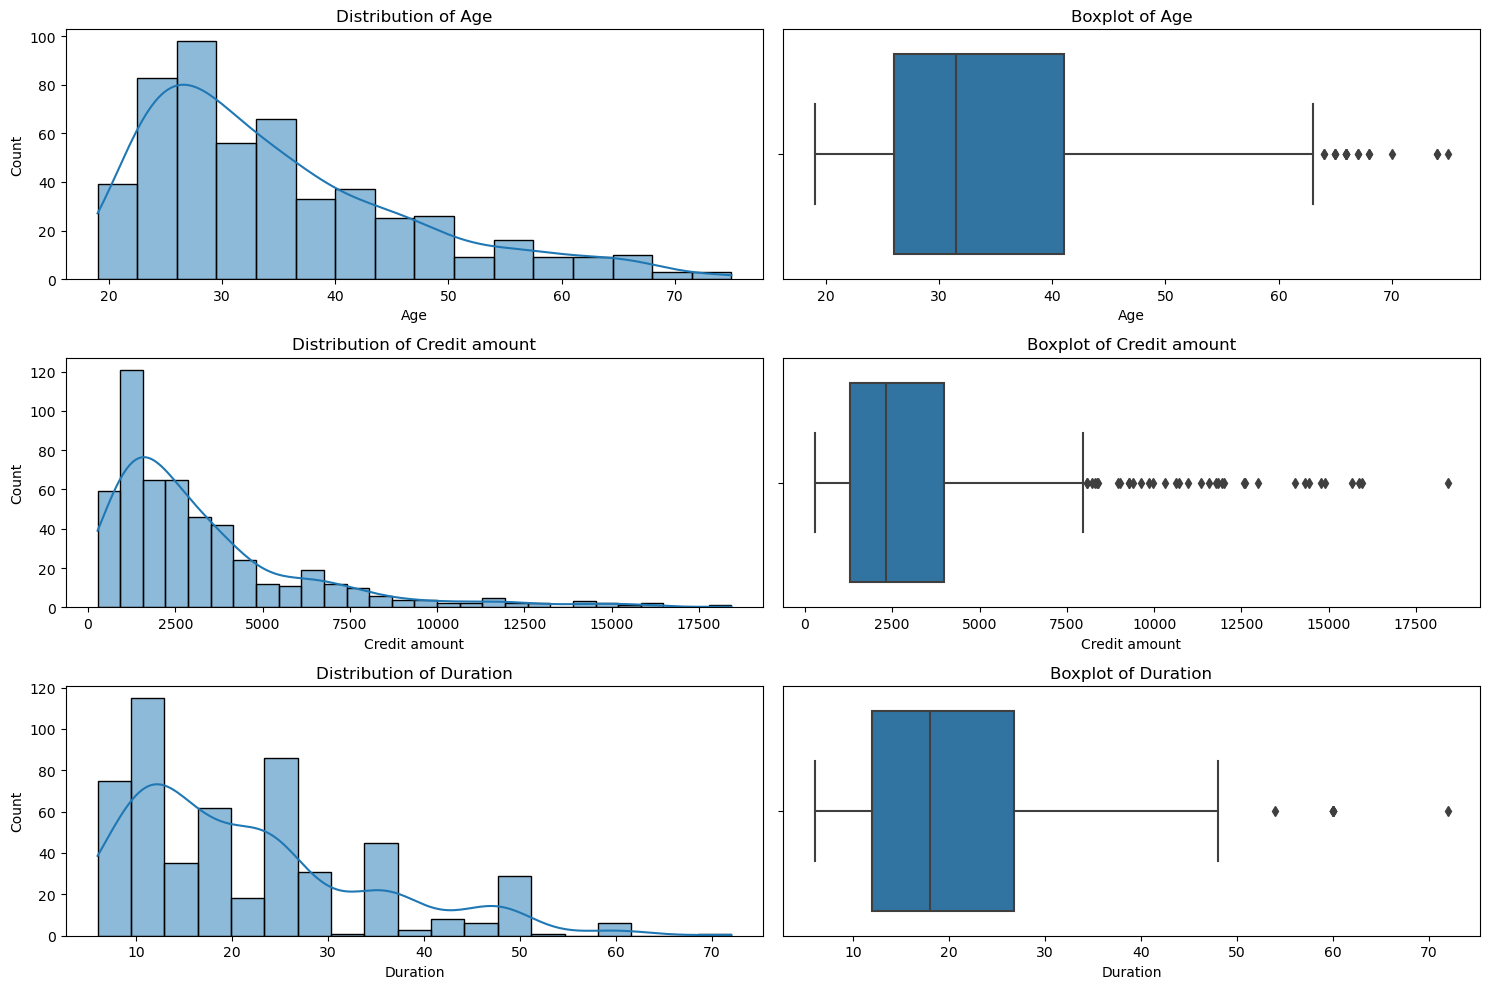

In [19]:
# List columns to create histograms and boxplots for
columns = ['Age', 'Credit amount', 'Duration']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create a histogram and boxplot for each column
for i, col in enumerate(columns):
    plt.subplot(3, 2, 2*i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

    plt.subplot(3, 2, 2*i + 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    
# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [20]:
# Define a function to calculate IQR and identify outliers
def iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identify and count outliers in each specified column using IQR method
outliers_age_iqr = iqr_outliers(df, 'Age')
outliers_credit_amount_iqr = iqr_outliers(df, 'Credit amount')
outliers_duration_iqr = iqr_outliers(df, 'Duration')

print("Number of outliers in 'Age' (IQR method):", len(outliers_age_iqr))
print("Number of outliers in 'Credit amount' (IQR method):", len(outliers_credit_amount_iqr))
print("Number of outliers in 'Duration' (IQR method):", len(outliers_duration_iqr))

Number of outliers in 'Age' (IQR method): 18
Number of outliers in 'Credit amount' (IQR method): 36
Number of outliers in 'Duration' (IQR method): 8


In [21]:
# Combine outlier indices into a set
outlier_indices = set(outliers_age_iqr.index).union(set(outliers_credit_amount_iqr.index)).union(set(outliers_duration_iqr.index))

# Drop outliers from the DataFrame
df.drop(outlier_indices, inplace=True)

# Print new shape of df
print("New shape of df:", df.shape)

New shape of df: (464, 9)


## Encoding Categorical Variables

In [22]:
# Get overview of df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 464 entries, 0 to 521
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               464 non-null    int64 
 1   Sex               464 non-null    object
 2   Job               464 non-null    int64 
 3   Housing           464 non-null    object
 4   Saving accounts   464 non-null    object
 5   Checking account  464 non-null    object
 6   Credit amount     464 non-null    int64 
 7   Duration          464 non-null    int64 
 8   Purpose           464 non-null    object
dtypes: int64(4), object(5)
memory usage: 36.2+ KB


In [23]:
# Get unique values in 'Sex' column
df['Sex'].unique()

array(['female', 'male'], dtype=object)

In [24]:
# Get unique values in 'Purpose' column
df['Purpose'].unique()

array(['radio/TV', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others', 'education'],
      dtype=object)

In [25]:
# Identify categorical variables for label encoding
le_cols = ['Housing', 'Saving accounts', 'Checking account']

In [26]:
# Identify categorical variables for one-hot encoding
ohe_cols = ['Sex', 'Purpose']

In [27]:
# Define custom label mappings
custom_mappings = {
    'Housing': {'rent': 1, 'free': 2, 'own': 3},
    'Saving accounts': {'little': 1, 'moderate': 2, 'rich': 3, 'quite rich': 4},
    'Checking account': {'little': 1, 'moderate': 2, 'rich': 3}
}

# Apply custom label mappings
for col, mapping in custom_mappings.items():
    df[col] = df[col].map(mapping)

In [28]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=ohe_cols, dtype=int)

In [29]:
# Check first few rows of df
df.head(20)

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Sex_female,Sex_male,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,22,2,3,1,2,5951,48,1,0,0,0,0,0,0,1,0,0
1,45,2,2,1,1,7882,42,0,1,0,0,0,0,1,0,0,0
2,53,2,2,1,1,4870,24,0,1,0,1,0,0,0,0,0,0
3,35,3,1,1,2,6948,36,0,1,0,1,0,0,0,0,0,0
4,28,3,3,1,2,5234,30,0,1,0,1,0,0,0,0,0,0
5,25,2,1,1,2,1295,12,1,0,0,1,0,0,0,0,0,0
6,24,2,1,1,1,4308,48,1,0,1,0,0,0,0,0,0,0
7,22,2,3,1,2,1567,12,1,0,0,0,0,0,0,1,0,0
8,60,1,3,1,1,1199,24,0,1,0,1,0,0,0,0,0,0
9,28,2,1,1,1,1403,15,1,0,0,1,0,0,0,0,0,0


## Creating New Features

### AgeGroup

In [30]:
# Compute quantiles
age_min = df['Age'].min()
age_q1 = df['Age'].quantile(0.25)
age_q2 = df['Age'].quantile(0.50)
age_q3 = df['Age'].quantile(0.75)
age_max = df['Age'].max()

# Print the quantiles
print(f"age_min: {age_min}")
print(f"age_q1: {age_q1}")
print(f"age_q2: {age_q2}")
print(f"age_q3: {age_q3}")
print(f"age_max: {age_max}")

# Define bins and labels
age_bins = [age_min, age_q1, age_q2, age_q3, age_max]
age_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Create AgeGroup feature
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True, right=True)

# Apply label mapping
df['AgeGroup'] = df['AgeGroup'].map({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})

# Convert data type to integer
df['AgeGroup'] = df['AgeGroup'].astype(int)

# Verify that AgeGroup works as expected
print("\n")
df[['Age', 'AgeGroup']].head(20)

age_min: 19
age_q1: 26.0
age_q2: 31.0
age_q3: 39.25
age_max: 63




,Age,AgeGroup
0,22,1
1,45,4
2,53,4
3,35,3
4,28,2
5,25,1
6,24,1
7,22,1
8,60,4
9,28,2


### CreditAmountGroup

In [31]:
# Compute quantiles
credit_min = df['Credit amount'].min()
credit_q1 = df['Credit amount'].quantile(0.25)
credit_q2 = df['Credit amount'].quantile(0.50)
credit_q3 = df['Credit amount'].quantile(0.75)
credit_max = df['Credit amount'].max()

# Print the quantiles
print(f"credit_min: {credit_min}")
print(f"credit_q1: {credit_q1}")
print(f"credit_q2: {credit_q2}")
print(f"credit_q3: {credit_q3}")
print(f"credit_max: {credit_max}")

# Define bins and labels
credit_bins = [credit_min, credit_q1, credit_q2, credit_q3, credit_max]
credit_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Create CreditAmountGroup feature
df['CreditAmountGroup'] = pd.cut(df['Credit amount'], bins=credit_bins, labels=credit_labels, include_lowest=True, right=True)

# Apply label mapping
df['CreditAmountGroup'] = df['CreditAmountGroup'].map({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})

# Convert data type to integer
df['CreditAmountGroup'] = df['CreditAmountGroup'].astype(int)

# Verify that CreditAmountGroup works as expected
print("\n")
df[['Credit amount', 'CreditAmountGroup']].head(20)

credit_min: 276
credit_q1: 1274.75
credit_q2: 2149.5
credit_q3: 3592.25
credit_max: 7966




,Credit amount,CreditAmountGroup
0,5951,4
1,7882,4
2,4870,4
3,6948,4
4,5234,4
5,1295,2
6,4308,4
7,1567,2
8,1199,1
9,1403,2


### DurationGroup

In [32]:
# Compute quantiles
duration_min = df['Duration'].min()
duration_q1 = df['Duration'].quantile(0.25)
duration_q2 = df['Duration'].quantile(0.50)
duration_q3 = df['Duration'].quantile(0.75)
duration_max = df['Duration'].max()

# Print the quantiles
print(f"duration_min: {duration_min}")
print(f"duration_q1: {duration_q1}")
print(f"duration_q2: {duration_q2}")
print(f"duration_q3: {duration_q3}")
print(f"duration_max: {duration_max}")

# Define bins and labels
duration_bins = [duration_min, duration_q1, duration_q2, duration_q3, duration_max]
duration_labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Create DurationGroup feature
df['DurationGroup'] = pd.cut(df['Duration'], bins=duration_bins, labels=duration_labels, include_lowest=True, right=True)

# Apply label mapping
df['DurationGroup'] = df['DurationGroup'].map({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})

# Convert data type to integer
df['DurationGroup'] = df['DurationGroup'].astype(int)

# Verify that DurationGroup works as expected
print("\n")
df[['Duration', 'DurationGroup']].head(20)

duration_min: 6
duration_q1: 12.0
duration_q2: 18.0
duration_q3: 24.0
duration_max: 48




,Duration,DurationGroup
0,48,4
1,42,4
2,24,3
3,36,4
4,30,4
5,12,1
6,48,4
7,12,1
8,24,3
9,15,2


### CreditToDuration

In [33]:
# Create CreditToDuration feature
df['CreditToDuration'] = df['Credit amount'] / df['Duration']

# Verify that CreditToDuration works as expected
df[['Credit amount', 'Duration', 'CreditToDuration']].head()

,Credit amount,Duration,CreditToDuration
0,5951,48,123.979167
1,7882,42,187.666667
2,4870,24,202.916667
3,6948,36,193.000000
4,5234,30,174.466667


### CreditCheckingInter

In [34]:
# Create CreditCheckingInter feature
df['CreditCheckingInter'] = df['CreditAmountGroup'] * df['Checking account']

# Verify that CreditCheckingInter works as expected
df[['CreditAmountGroup', 'Checking account', 'CreditCheckingInter']].head()

,CreditAmountGroup,Checking account,CreditCheckingInter
0,4,2,8
1,4,1,4
2,4,1,4
3,4,2,8
4,4,2,8


### CreditSavingInter

In [35]:
# Create CreditSavingInter feature
df['CreditSavingInter'] = df['CreditAmountGroup'] * df['Saving accounts']

# Verify that CreditSavingInter works as expected
df[['CreditAmountGroup', 'Saving accounts', 'CreditSavingInter']].head()

,CreditAmountGroup,Saving accounts,CreditSavingInter
0,4,1,4
1,4,1,4
2,4,1,4
3,4,1,4
4,4,1,4


### CreditCheckingSavingInter

In [36]:
# Create CreditCheckingSavingInter feature
df['CreditCheckingSavingInter'] = df['CreditAmountGroup'] * df['Checking account'] * df['Saving accounts']

# Verify that CreditCheckingSavingInter works as expected
df[['CreditAmountGroup', 'Checking account', 'Saving accounts', 'CreditCheckingSavingInter']].head()

,CreditAmountGroup,Checking account,Saving accounts,CreditCheckingSavingInter
0,4,2,1,8
1,4,1,1,4
2,4,1,1,4
3,4,2,1,8
4,4,2,1,8


### PurposeIsBizOrEduc

In [37]:
# Create PurposeIsBizOrEduc feature, which checks if purpose of credit application is likely to generate future income
df['PurposeIsBizOrEduc'] = ((df['Purpose_business'] == 1) | (df['Purpose_education'] == 1)).astype(int)

# Verify that PurposeIsBusinessOrEducation works as expected
df[['Purpose_business', 'Purpose_education', 'PurposeIsBizOrEduc']].head()

,Purpose_business,Purpose_education,PurposeIsBizOrEduc
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


### AgeJobInter

In [38]:
# Create AgeJobInter feature
df['AgeJobInter'] = df['AgeGroup'] * df['Job']

# Verify that AgeJobInter works as expected
df[['AgeGroup', 'Job', 'AgeJobInter']].head()

,AgeGroup,Job,AgeJobInter
0,1,2,2
1,4,2,8
2,4,2,8
3,3,3,9
4,2,3,6


### AgeCreditInter

In [39]:
# Create AgeCreditInter feature
df['AgeCreditInter'] = df['AgeGroup'] * df['CreditAmountGroup']

# Verify that AgeCreditInter works as expected
df[['AgeGroup', 'CreditAmountGroup', 'AgeCreditInter']].head()

,AgeGroup,CreditAmountGroup,AgeCreditInter
0,1,4,4
1,4,4,16
2,4,4,16
3,3,4,12
4,2,4,8


### AgeDurationInter

In [40]:
# Create AgeDurationInter feature
df['AgeDurationInter'] = df['AgeGroup'] * df['DurationGroup']

# Verify that AgeDurationInter works as expected
df[['AgeGroup', 'DurationGroup', 'AgeDurationInter']].head()

,AgeGroup,DurationGroup,AgeDurationInter
0,1,4,4
1,4,4,16
2,4,3,12
3,3,4,12
4,2,4,8


### CreditDurationInter

In [41]:
# Create CreditDurationInter feature
df['CreditDurationInter'] = df['CreditAmountGroup'] * df['DurationGroup']

# Verify that CreditDurationInter works as expected
df[['CreditAmountGroup', 'DurationGroup', 'CreditDurationInter']].head()

,CreditAmountGroup,DurationGroup,CreditDurationInter
0,4,4,16
1,4,4,16
2,4,3,12
3,4,4,16
4,4,4,16


### SavingCheckingInter

In [42]:
# Create SavingCheckingInter feature
df['SavingCheckingInter'] = df['Saving accounts'] + df['Checking account']

# Verify that SavingCheckingInter works as expected
df[['Saving accounts', 'Checking account', 'SavingCheckingInter']].head()

,Saving accounts,Checking account,SavingCheckingInter
0,1,2,3
1,1,1,2
2,1,1,2
3,1,2,3
4,1,2,3


## Ensuring Correct Data Types

In [43]:
# Check data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 464 entries, 0 to 521
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          464 non-null    int64  
 1   Job                          464 non-null    int64  
 2   Housing                      464 non-null    int64  
 3   Saving accounts              464 non-null    int64  
 4   Checking account             464 non-null    int64  
 5   Credit amount                464 non-null    int64  
 6   Duration                     464 non-null    int64  
 7   Sex_female                   464 non-null    int32  
 8   Sex_male                     464 non-null    int32  
 9   Purpose_business             464 non-null    int32  
 10  Purpose_car                  464 non-null    int32  
 11  Purpose_domestic appliances  464 non-null    int32  
 12  Purpose_education            464 non-null    int32  
 13  Purpose_furniture/equipme

# Exploratory Data Analysis

In [44]:
# Get summary statistics
df.describe()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Sex_female,Sex_male,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,AgeGroup,CreditAmountGroup,DurationGroup,CreditToDuration,CreditCheckingInter,CreditSavingInter,CreditCheckingSavingInter,PurposeIsBizOrEduc,AgeJobInter,AgeCreditInter,AgeDurationInter,CreditDurationInter,SavingCheckingInter
count,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000
mean,33.517241,1.834052,2.465517,1.338362,1.622845,2631.353448,19.868534,0.327586,0.672414,0.094828,0.316810,0.012931,0.049569,0.224138,0.269397,0.023707,0.008621,2.431034,2.500000,2.232759,143.459633,4.017241,3.321121,5.465517,0.144397,4.517241,6.137931,5.394397,6.362069,2.961207
std,10.077225,0.640973,0.825417,0.752070,0.671863,1763.551530,10.967947,0.469840,0.469840,0.293293,0.465735,0.113099,0.217287,0.417463,0.444125,0.152299,0.092546,1.156999,1.119241,1.170979,89.989799,2.487924,2.445586,4.830485,0.351871,2.797663,4.225085,4.078290,5.161574,1.073238
min,19.000000,0.000000,1.000000,1.000000,1.000000,276.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,26.133333,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,26.000000,1.000000,2.000000,1.000000,1.000000,1274.750000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.750000,1.000000,80.729167,2.000000,2.000000,2.000000,0.000000,2.000000,3.000000,2.000000,2.000000,2.000000
50%,31.000000,2.000000,3.000000,1.000000,2.000000,2149.500000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.500000,2.000000,123.864583,4.000000,3.000000,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000,3.000000
75%,39.250000,2.000000,3.000000,1.000000,2.000000,3592.250000,24.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.250000,3.250000,3.000000,171.646825,6.000000,4.000000,8.000000,0.000000,6.000000,8.000000,8.000000,12.000000,4.000000
max,63.000000,3.000000,3.000000,4.000000,3.000000,7966.000000,48.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,655.416667,12.000000,16.000000,36.000000,1.000000,12.000000,16.000000,16.000000,16.000000,7.000000


The range varies widely across variables. Since clustering algorithms like K-means clustering are distance-based, variables with larger scales or ranges can disproportionately influence the clustering process because the distance metric would be dominated by those variables. Scaling is necessary to bring all variables to a comparable range and prevent this issue.

<Axes: >

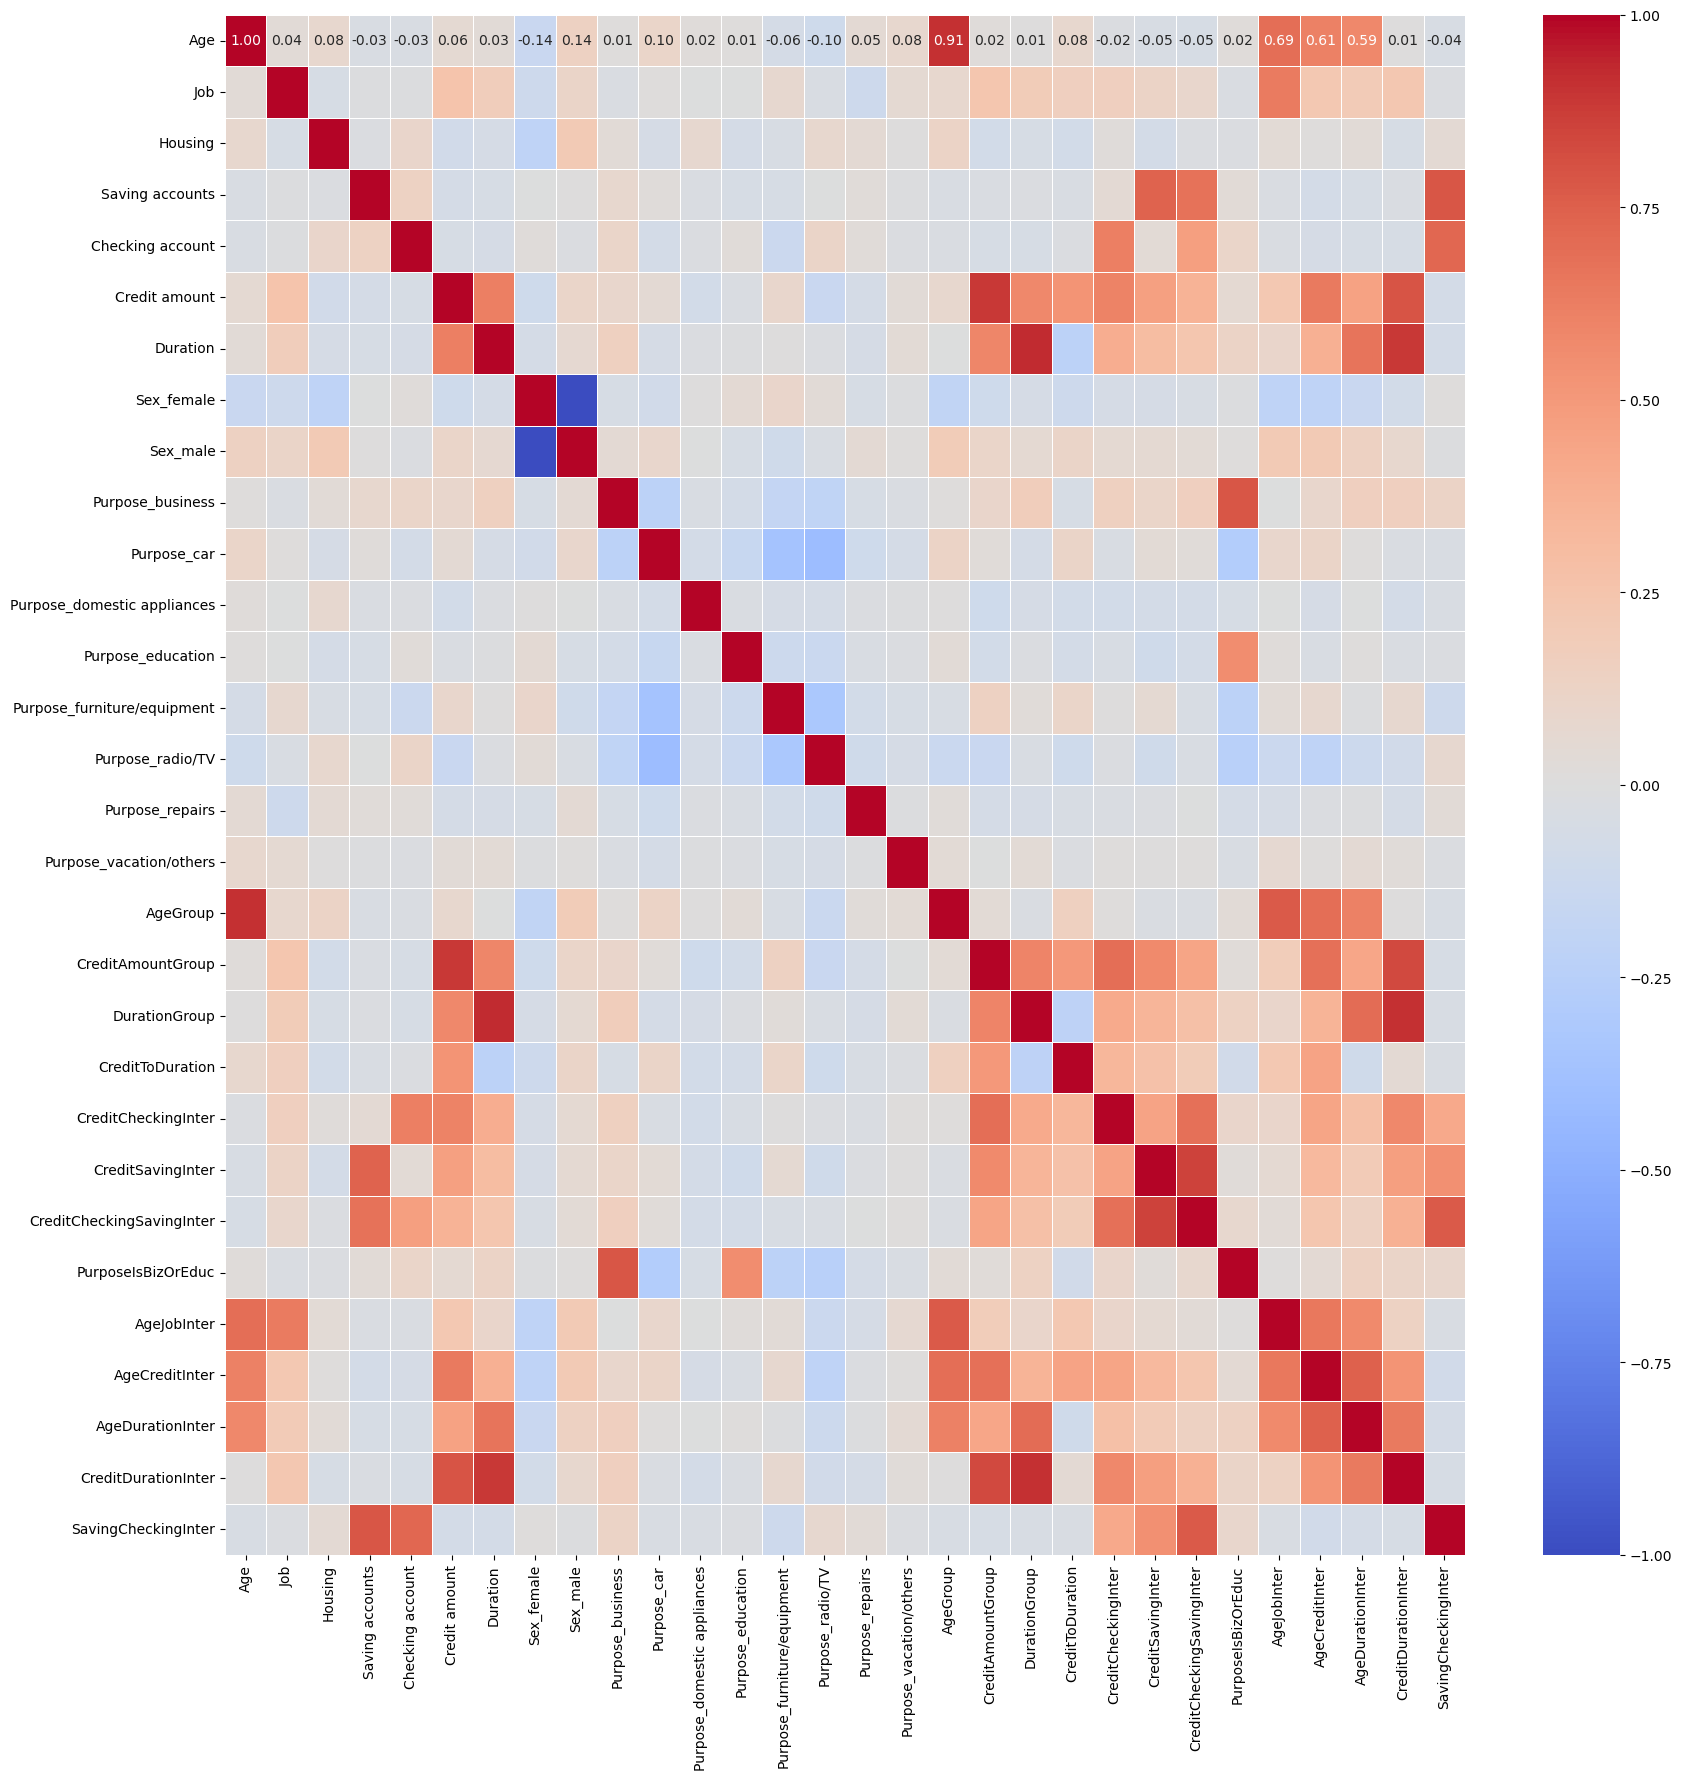

In [45]:
# Create a correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [46]:
# Set correlation thresholds
highly_correlated_threshold = 0.7
moderately_correlated_threshold = 0.5

# Create a list to store correlated pairs, correlation values, and correlation levels
correlated_pairs = []

# Define function to determine correlation level
def get_correlation_level(correlation_value):
    if abs(correlation_value) >= highly_correlated_threshold:
        return 'Highly correlated'
    elif abs(correlation_value) >= moderately_correlated_threshold:
        return 'Moderately correlated'
    else:
        return None

# Iterate through pairs of features and accumulate moderately and highly correlated pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        feature1, feature2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
        correlation_value = correlation_matrix.loc[feature1, feature2]
        correlation_level = get_correlation_level(correlation_value)
        
        if correlation_level is not None:
            correlated_pairs.append({'Feature 1': feature1,
                                     'Feature 2': feature2,
                                     'Correlation Value': correlation_value,
                                     'Correlation Level': correlation_level})

# Convert the list of dictionaries into a DataFrame
correlated_pairs_df = pd.DataFrame(correlated_pairs)

print(correlated_pairs_df)

                    Feature 1                  Feature 2  Correlation Value      Correlation Level
0                         Age                   AgeGroup           0.913913      Highly correlated
1                         Age                AgeJobInter           0.689705  Moderately correlated
2                         Age             AgeCreditInter           0.613086  Moderately correlated
3                         Age           AgeDurationInter           0.585619  Moderately correlated
4                         Job                AgeJobInter           0.640552  Moderately correlated
5             Saving accounts          CreditSavingInter           0.735795      Highly correlated
6             Saving accounts  CreditCheckingSavingInter           0.676518  Moderately correlated
7             Saving accounts        SavingCheckingInter           0.784272      Highly correlated
8            Checking account        CreditCheckingInter           0.618946  Moderately correlated
9         

Clustering algorithms are sensitive to multicollinearity as it can distort distance measures, impact algorithms, and introduce redundant information. Handling multicollinearity can lead to more reliable and interpretable clustering results.

# Feature Selection

In [47]:
# List all features
df.columns

Index(['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male', 'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others', 'AgeGroup', 'CreditAmountGroup', 'DurationGroup', 'CreditToDuration', 'CreditCheckingInter', 'CreditSavingInter', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc', 'AgeJobInter', 'AgeCreditInter', 'AgeDurationInter', 'CreditDurationInter', 'SavingCheckingInter'], dtype='object')

## Variance Threshold

Features with low variance need to be identified as they might not contribute significantly to clustering.

In [48]:
# Define the variance threshold
threshold = 0.1

# Fit the VarianceThreshold
selector = VarianceThreshold(threshold=threshold)
selector.fit(df)

# Get the variances of all features
variances = selector.variances_

# Identify features with variance below the threshold
low_variance_features = [column for column, variance in zip(df.columns, variances) if variance < threshold]

# Print the low variance features
print("Features with low variance:", low_variance_features)

Features with low variance: ['Purpose_business', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_repairs', 'Purpose_vacation/others']


## Correlation Threshold

Highly correlated features can be redundant, and it might be beneficial to remove some to reduce dimensionality.  One of each pair of features with a correlation coefficient higher than a certain threshold (e.g., 0.7) can be removed.

The following pairs of features have a correlation coefficient greater than or equal to 0.7.

In [49]:
# Filter correlated_pairs_df for 'Highly correlated' pairs
highly_correlated_pairs = correlated_pairs_df[correlated_pairs_df['Correlation Level'] == 'Highly correlated']

# Extract the pairs of features
highly_correlated_features = highly_correlated_pairs[['Feature 1', 'Feature 2']]

# Display the result
highly_correlated_features.reset_index(drop=True)

,Feature 1,Feature 2
0,Age,AgeGroup
1,Saving accounts,CreditSavingInter
2,Saving accounts,SavingCheckingInter
3,Checking account,SavingCheckingInter
4,Credit amount,CreditAmountGroup
5,Credit amount,CreditDurationInter
6,Duration,DurationGroup
7,Duration,CreditDurationInter
8,Sex_female,Sex_male
9,Purpose_business,PurposeIsBizOrEduc


# Scaling

In [50]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Convert back to DataFrame
X = pd.DataFrame(X, columns=df.columns)

# List columns
X.columns

Index(['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male', 'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others', 'AgeGroup', 'CreditAmountGroup', 'DurationGroup', 'CreditToDuration', 'CreditCheckingInter', 'CreditSavingInter', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc', 'AgeJobInter', 'AgeCreditInter', 'AgeDurationInter', 'CreditDurationInter', 'SavingCheckingInter'], dtype='object')

# Model Development and Evaluation

## Clustering 1 - KMeans, 9 Features, 5 Clusters

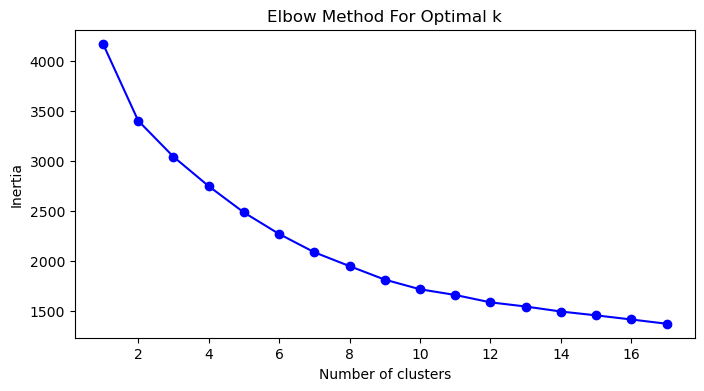

In [51]:
# Select features to be used
features_1 = ['Job', 'Housing', 'Sex_male', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc', 'AgeJobInter', 'AgeDurationInter', 'CreditDurationInter']
              
# Subset the DataFrame
X_1 = X[features_1]

# Determine optimal number of clusters via Elbow Method
inertia_values = []
K = range(1, 18)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_1)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

The Elbow Method involves plotting the within-cluster sum of squares (inertia) against the number of clusters. The point at which the inertia starts to decrease more slowly (forming an "elbow") suggests an appropriate number of clusters

In [52]:
# Set optimal number of clusters
n_clusters_1 = 5

# Apply KMeans clustering using the optimal number of clusters
kmeans_1 = KMeans(n_clusters=n_clusters_1, random_state=42)
kmeans_1.fit(X_1)

# Get the cluster labels
labels_1 = kmeans_1.labels_

# Compute evaluation metrics
silhouette_1 = silhouette_score(X_1, labels_1)
print(f"Silhouette Score: {silhouette_1:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_1 = davies_bouldin_score(X_1, labels_1)
print(f"\nDavies-Bouldin Index: {davies_bouldin_1:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

inertia_1 = kmeans_1.inertia_
print(f"\nInertia: {inertia_1:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.184026 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.653774 
(Range of possible values is [0, ∞). The lower the value, the better.)

Inertia: 2484.857308 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 2 - Hierarchical Clustering, 9 Features, 3 Clusters

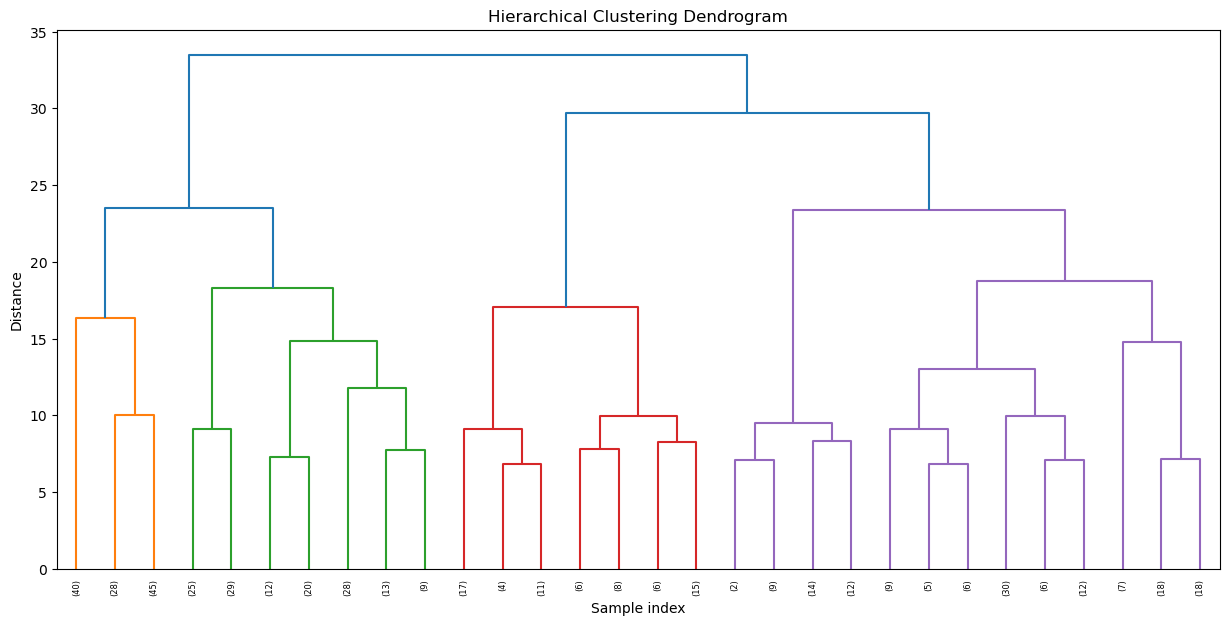

In [53]:
# Select features to be used
features_2 = ['Job', 'Housing', 'Sex_male', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc', 'AgeJobInter', 'AgeDurationInter', 'CreditDurationInter']

# Subset the DataFrame
X_2 = X[features_2]

# Generate the linkage matrix
Z_2 = linkage(X_2, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_2, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.show()

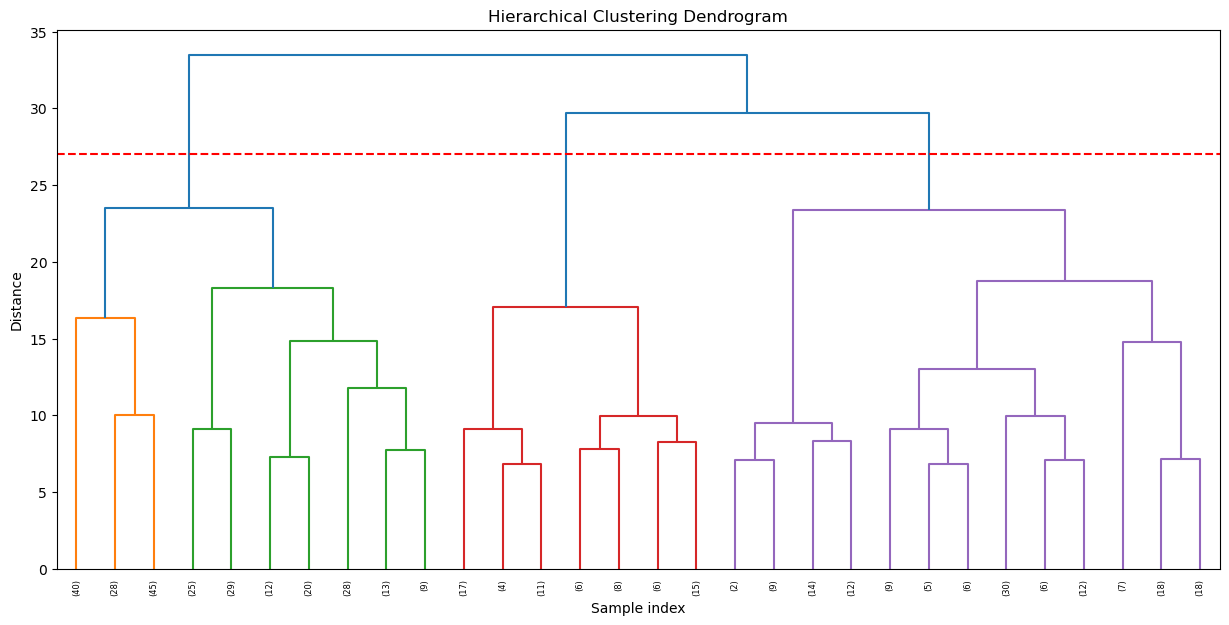

In [54]:
# Set threshold distance and optimal number of clusters
threshold_distance_2 = 27
n_clusters_2 = 3

# Add horizontal line to dendrogram for threshold
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_2, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.axhline(y=threshold_distance_2, color='r', linestyle='--')  
plt.show()

# Form clusters based on this threshold distance
labels_2 = fcluster(Z_2, threshold_distance_2, criterion='distance')

Deciding the threshold distance in hierarchical clustering is a crucial step that determines the number of clusters. One of the most intuitive methods to determine the threshold distance is to visually inspect the dendrogram. A large jump or gap in the vertical distance between merged clusters indicates a natural division between clusters. At threshold_distance=27, indicated by the red horizontal dashed line, there is a large gap in the vertical distance between merged clusters. The number of vertical lines intersected by this horizontal line indicates the number of clusters, in this case, 3.

In [55]:
# Compute evaluation metrics
silhouette_2 = silhouette_score(X_2, labels_2)
print(f"Silhouette Score: {silhouette_2:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_2 = davies_bouldin_score(X_2, labels_2)
print(f"\nDavies-Bouldin Index: {davies_bouldin_2:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.182414 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 2.020926 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 3 - KMeans, 5 Features, 6 Clusters

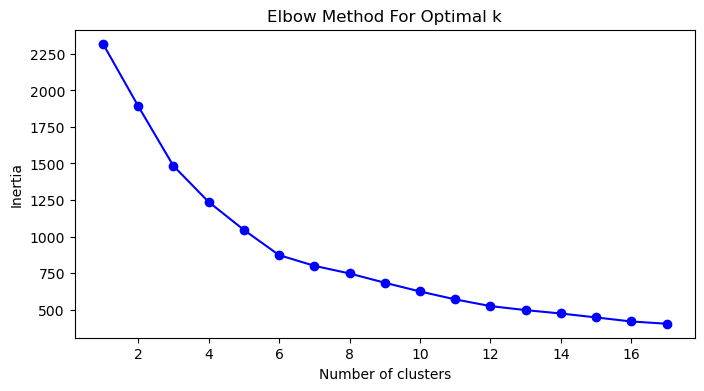

In [56]:
# Select features to be used
features_3 = ['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc']

# Subset the DataFrame
X_3 = X[features_3]

# Determine optimal number of clusters via Elbow Method
inertia_values = []
K = range(1, 18)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_3)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [57]:
# Set optimal number of clsuters
n_clusters_3 = 6

# Apply KMeans clustering using the optimal number of clusters
kmeans_3 = KMeans(n_clusters=n_clusters_3, random_state=42)
kmeans_3.fit(X_3)

# Get the cluster labels
labels_3 = kmeans_3.labels_

# Compute evaluation metrics
silhouette_3 = silhouette_score(X_3, labels_3)
print(f"Silhouette Score: {silhouette_3:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_3 = davies_bouldin_score(X_3, labels_3)
print(f"\nDavies-Bouldin Index: {davies_bouldin_3:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

inertia_3 = kmeans_3.inertia_
print(f"\nInertia: {inertia_3:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.352973 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 0.964786 
(Range of possible values is [0, ∞). The lower the value, the better.)

Inertia: 872.543308 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 4 - Hierarchical Clustering, 5 Features, 6 Clusters

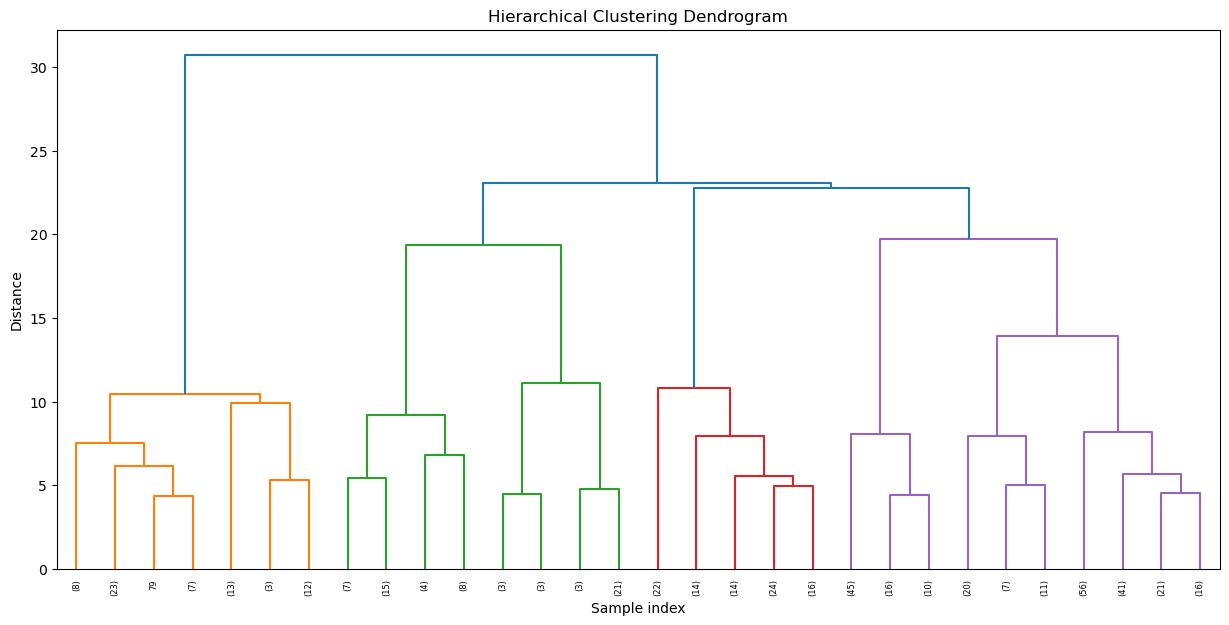

In [58]:
# Select features to be used
features_4 = ['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc']

# Subset the DataFrame
X_4 = X[features_4]

# Generate the linkage matrix
Z_4 = linkage(X_4, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_4, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.show()

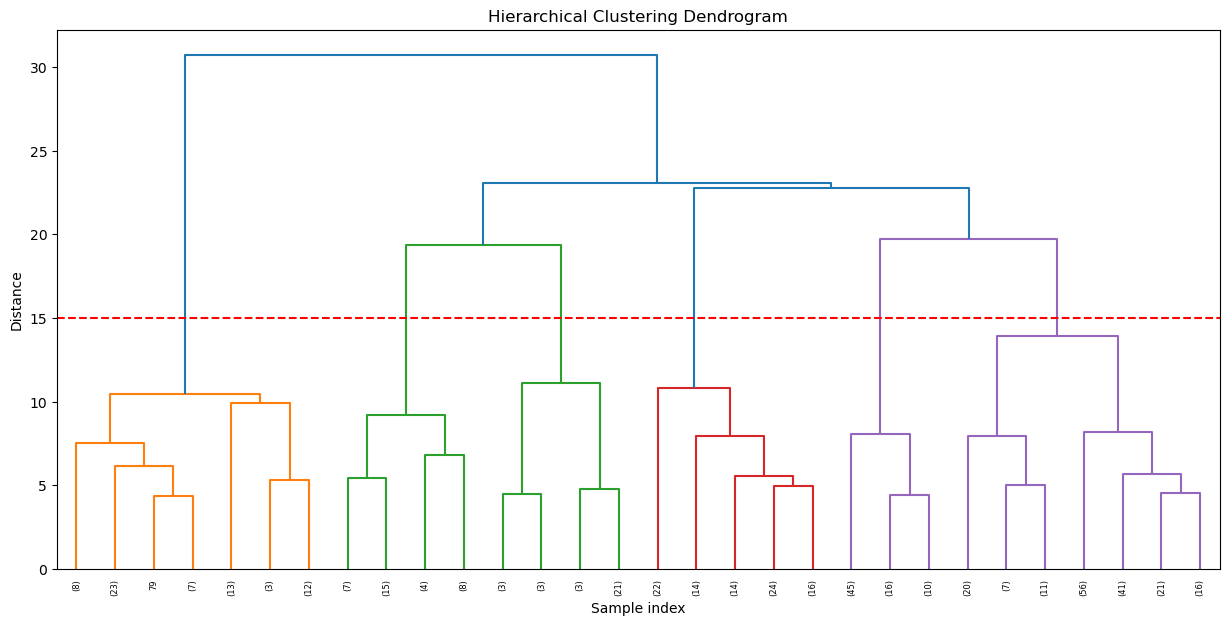

In [59]:
# Set threshold distance and optimal number of clusters
threshold_distance_4 = 15
n_clusters_4 = 6

# Add horizontal line to dendrogram for threshold
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_4, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.axhline(y=threshold_distance_4, color='r', linestyle='--')  
plt.show()

# Form clusters based on this threshold distance
labels_4 = fcluster(Z_4, threshold_distance_4, criterion='distance')

In [60]:
# Compute evaluation metrics
silhouette_4 = silhouette_score(X_4, labels_4)
print(f"Silhouette Score: {silhouette_4:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_4 = davies_bouldin_score(X_4, labels_4)
print(f"\nDavies-Bouldin Index: {davies_bouldin_4:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.322300 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.005666 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 5 - KMeans, 4 Features, 5 Clusters

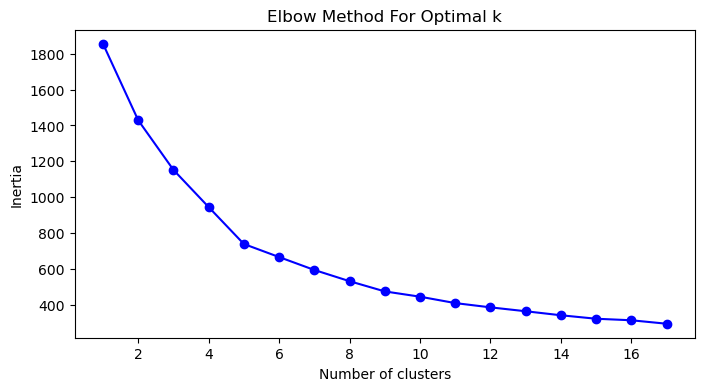

In [61]:
# Select features to be used
features_5 = ['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']

# Subset the DataFrame
X_5 = X[features_5]

# Determine optimal number of clusters via Elbow Method
inertia_values = []
K = range(1, 18)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_5)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [62]:
# Set optimal number of clusters
n_clusters_5 = 5

# Apply KMeans clustering using the optimal number of clusters
kmeans_5 = KMeans(n_clusters=n_clusters_5, random_state=42)
kmeans_5.fit(X_5)

# Get the cluster labels
labels_5 = kmeans_5.labels_

# Compute evaluation metrics
silhouette_5 = silhouette_score(X_5, labels_5)
print(f"Silhouette Score: {silhouette_5:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_5 = davies_bouldin_score(X_5, labels_5)
print(f"\nDavies-Bouldin Index: {davies_bouldin_5:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

inertia_5 = kmeans_5.inertia_
print(f"\nInertia: {inertia_5:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.366220 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 0.974776 
(Range of possible values is [0, ∞). The lower the value, the better.)

Inertia: 738.084150 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 6 - Hierarchical Clustering, 4 Features, 5 Clusters

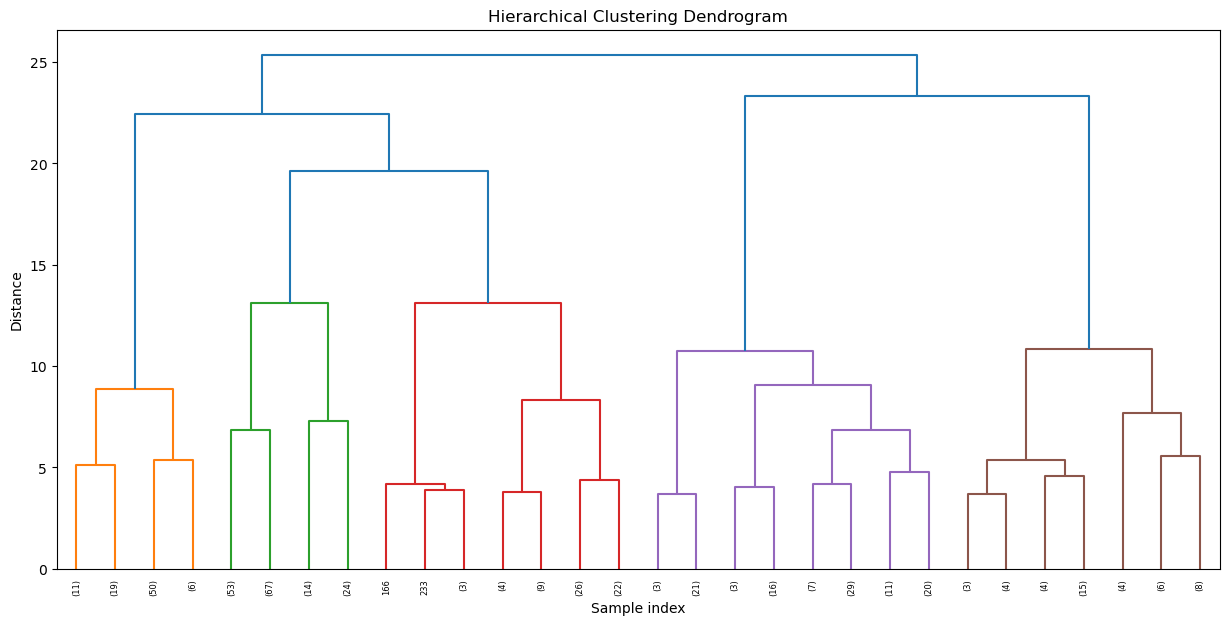

In [63]:
# Select features to be used
features_6 = ['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']

# Subset the DataFrame
X_6 = X[features_6]

# Generate the linkage matrix
Z_6 = linkage(X_6, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_6, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.show()

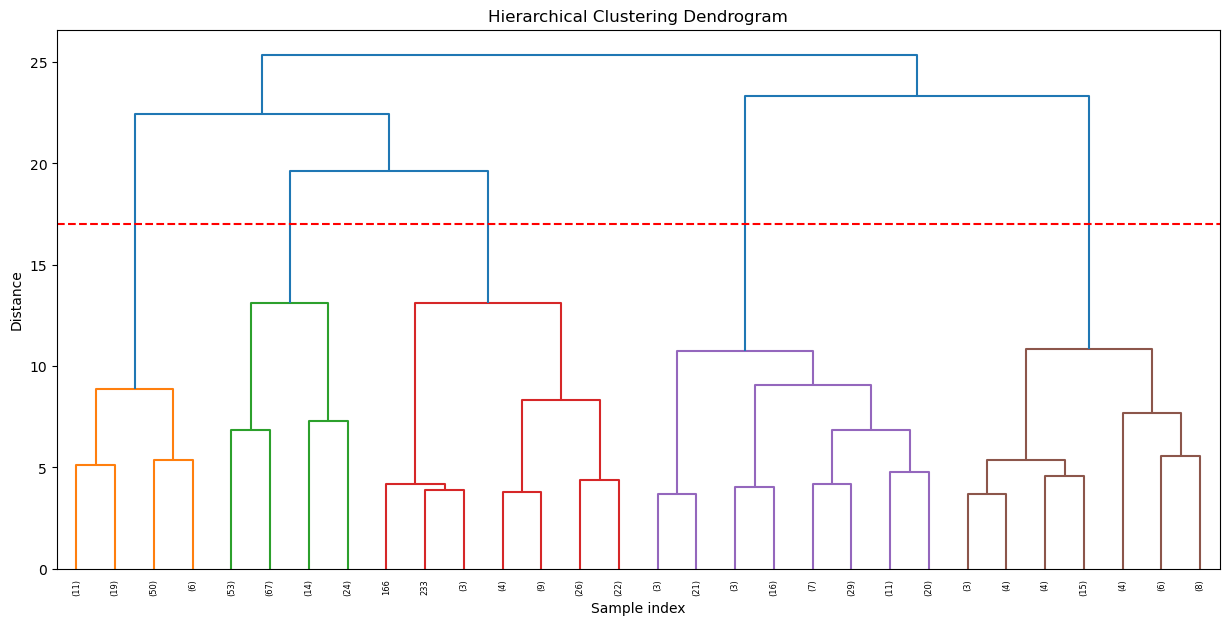

In [64]:
# Set threshold distance and optimal number of clusters
threshold_distance_6 = 17
n_clusters_6 = 5

# Add horizontal line to dendrogram for threshold
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_6, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.axhline(y=threshold_distance_6, color='r', linestyle='--')  
plt.show()

# Form clusters based on this threshold distance
labels_6 = fcluster(Z_6, threshold_distance_6, criterion='distance')

In [65]:
# Compute evaluation metrics
silhouette_6 = silhouette_score(X_6, labels_6)
print(f"Silhouette Score: {silhouette_6:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_6 = davies_bouldin_score(X_6, labels_6)
print(f"\nDavies-Bouldin Index: {davies_bouldin_6:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.321484 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.047177 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 7 - KMeans, 4 Features, 2 Clusters

In [66]:
# Select features to be used
features_7 = ['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']

# Subset the DataFrame
X_7 = X[features_7]

# Set optimal number of clusters
n_clusters_7 = 2

# Apply KMeans clustering using the optimal number of clusters
kmeans_7 = KMeans(n_clusters=n_clusters_7, random_state=42)
kmeans_7.fit(X_7)

# Get the cluster labels
labels_7 = kmeans_7.labels_

# Compute evaluation metrics
silhouette_7 = silhouette_score(X_7, labels_7)
print(f"Silhouette Score: {silhouette_7:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_7 = davies_bouldin_score(X_7, labels_7)
print(f"\nDavies-Bouldin Index: {davies_bouldin_7:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

inertia_7 = kmeans_7.inertia_
print(f"\nInertia: {inertia_7:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")


Silhouette Score: 0.315892 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.509277 
(Range of possible values is [0, ∞). The lower the value, the better.)

Inertia: 1429.026372 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 8 - Hierarchical Clustering, 4 Features, 2 Clusters

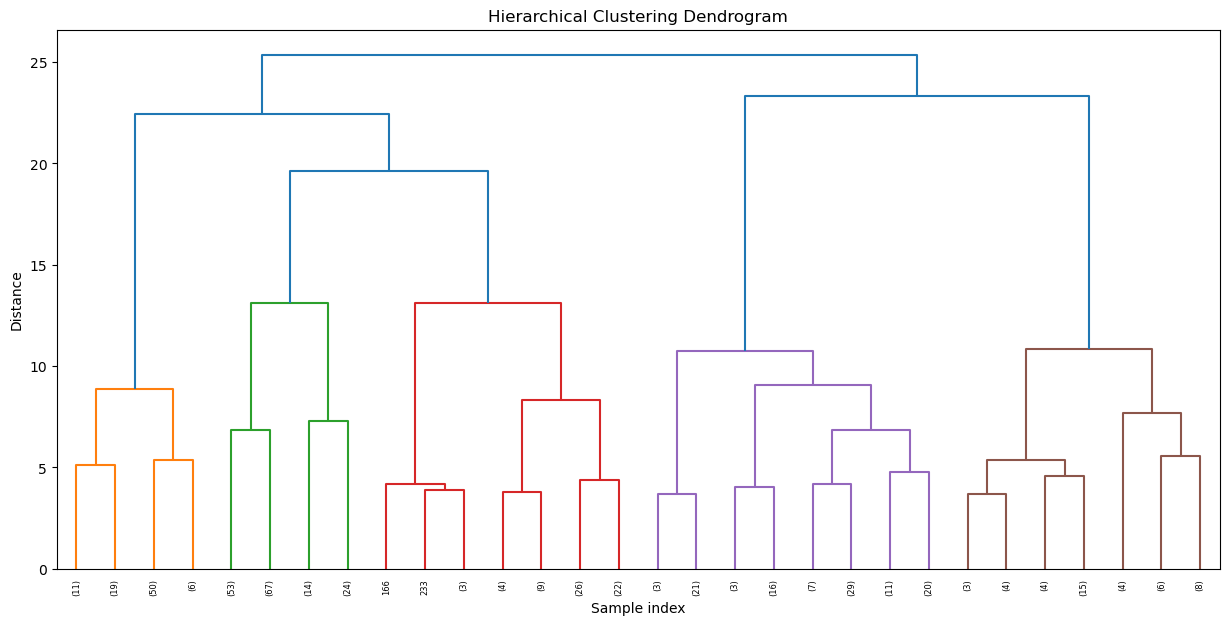

In [67]:
# Select features to be used
features_8 = ['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']

# Subset the DataFrame
X_8 = X[features_8]

# Generate the linkage matrix
Z_8 = linkage(X_8, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_8, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.show()

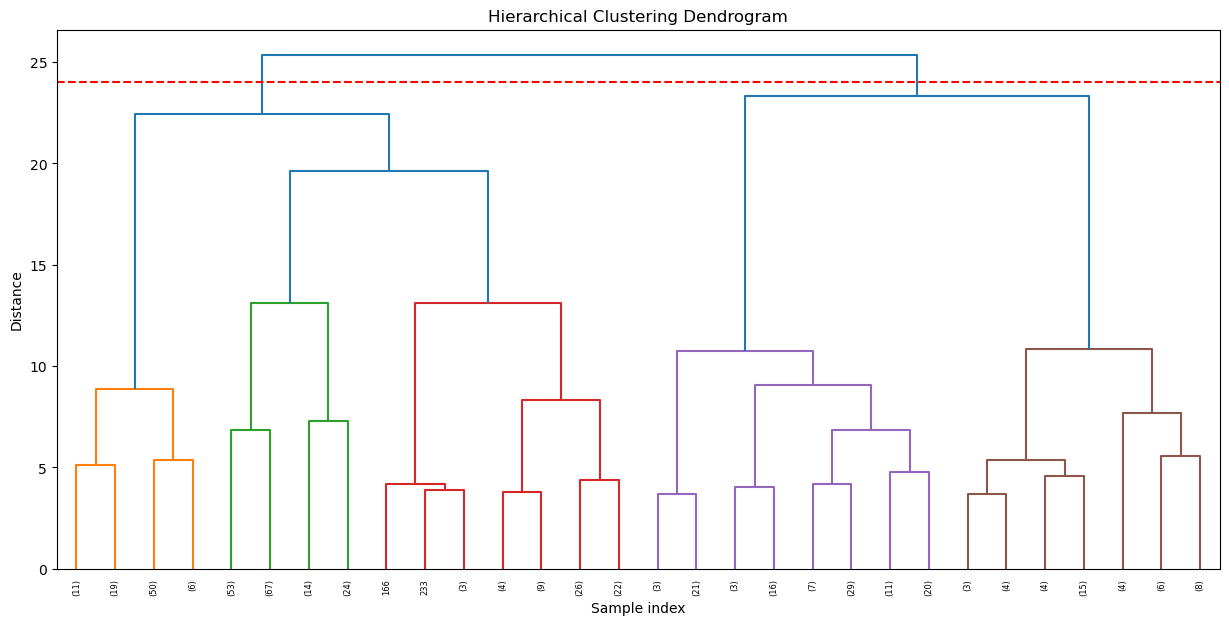

In [68]:
# Set threshold distance and optimal number of clusters
threshold_distance_8 = 24
n_clusters_8 = 2

# Add horizontal line to dendrogram for threshold
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_8, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.axhline(y=threshold_distance_8, color='r', linestyle='--')  
plt.show()

# Form clusters based on this threshold distance
labels_8 = fcluster(Z_8, threshold_distance_8, criterion='distance')

In [69]:
# Compute evaluation metrics
silhouette_8 = silhouette_score(X_8, labels_8)
print(f"Silhouette Score: {silhouette_8:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_8 = davies_bouldin_score(X_8, labels_8)
print(f"\nDavies-Bouldin Index: {davies_bouldin_8:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.264357 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.867319 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 9 - KMeans, 8 Features, 5 Clusters

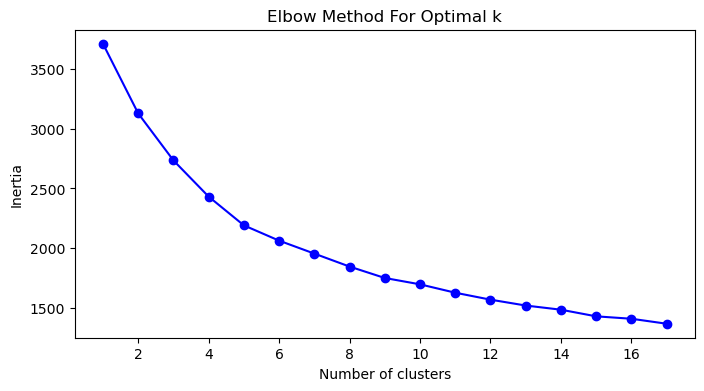

In [70]:
# Select features to be used
features_9 = ['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Sex_male']

# Subset the DataFrame
X_9 = X[features_9]

# Determine optimal number of clusters via Elbow Method
inertia_values = []
K = range(1, 18)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_9)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [71]:
# Set optimal number of clusters
n_clusters_9 = 5

# Apply KMeans clustering using the optimal number of clusters
kmeans_9 = KMeans(n_clusters=n_clusters_9, random_state=42)
kmeans_9.fit(X_9)

# Get the cluster labels
labels_9 = kmeans_9.labels_

# Compute evaluation metrics
silhouette_9 = silhouette_score(X_9, labels_9)
print(f"Silhouette Score: {silhouette_9:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_9 = davies_bouldin_score(X_9, labels_9)
print(f"\nDavies-Bouldin Index: {davies_bouldin_9:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

inertia_9 = kmeans_9.inertia_
print(f"\nInertia: {inertia_9:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.191069 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.585440 
(Range of possible values is [0, ∞). The lower the value, the better.)

Inertia: 2190.451855 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 10 - Hierarchical Clustering, 8 Features, 5 Clusters

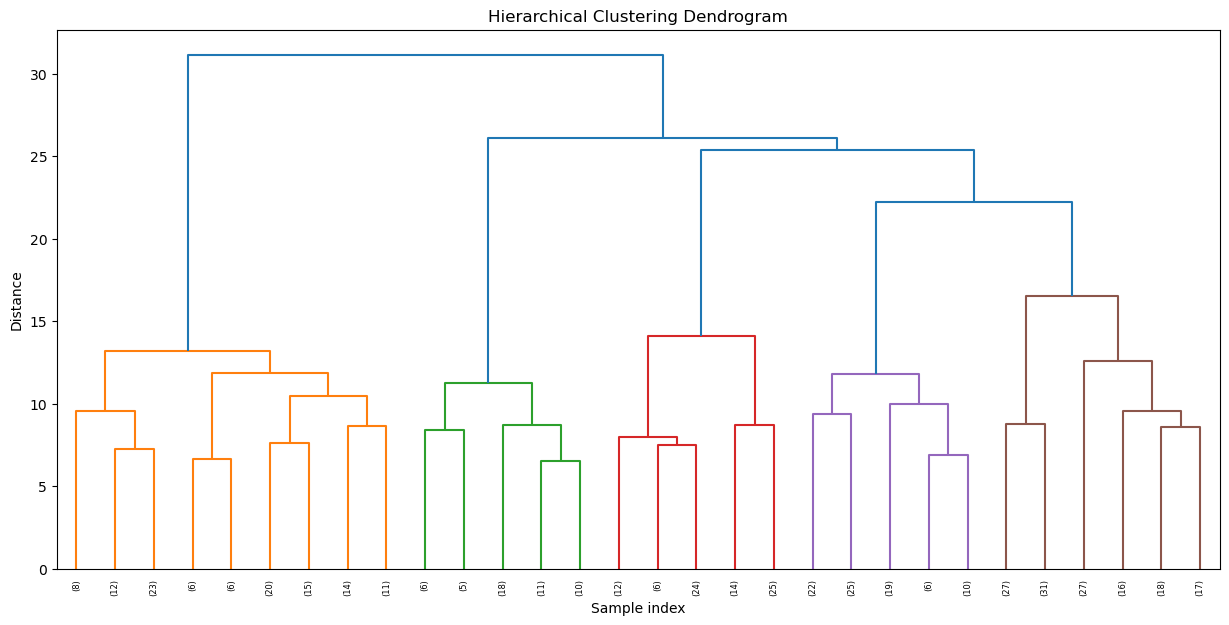

In [72]:
# Select features to be used
features_10 = ['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Sex_male']

# Subset the DataFrame
X_10 = X[features_10]

# Generate the linkage matrix
Z_10 = linkage(X_10, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_10, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.show()

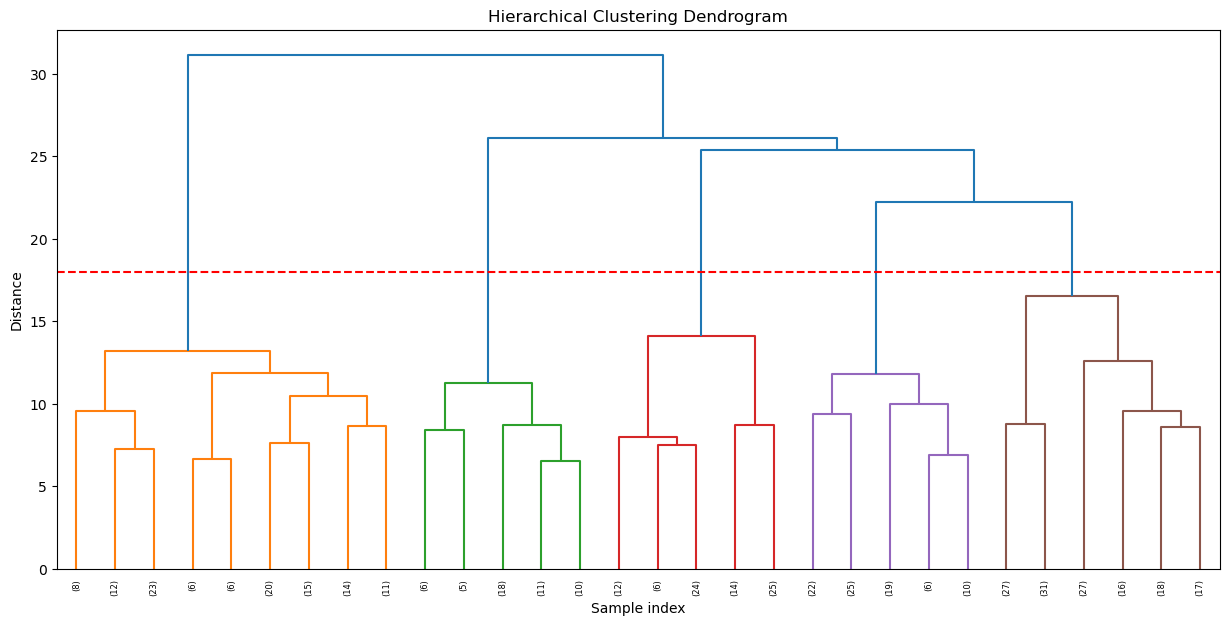

In [73]:
# Set threshold distance and optimal number of clusters
threshold_distance_10 = 18
n_clusters_10 = 5

# Add horizontal line to dendrogram for threshold
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_10, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.axhline(y=threshold_distance_10, color='r', linestyle='--')  
plt.show()

# Form clusters based on this threshold distance
labels_10 = fcluster(Z_10, threshold_distance_10, criterion='distance')

In [74]:
# Compute evaluation metrics
silhouette_10 = silhouette_score(X_10, labels_10)
print(f"Silhouette Score: {silhouette_10:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_10 = davies_bouldin_score(X_10, labels_10)
print(f"\nDavies-Bouldin Index: {davies_bouldin_10:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.162574 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 1.682198 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 11 - KMeans, 2 Features, 5 Clusters

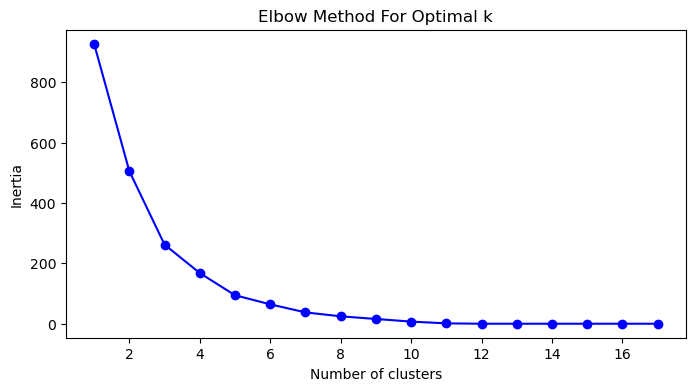

In [75]:
# Select features to be used
features_11 = ['Job', 'Housing']

# Subset the DataFrame
X_11 = X[features_11]

# Determine optimal number of clusters via Elbow Method
inertia_values = []
K = range(1, 18)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_11)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia_values, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [76]:
# Set optimal number of clusters
n_clusters_11 = 5

# Apply KMeans clustering using the optimal number of clusters
kmeans_11 = KMeans(n_clusters=n_clusters_11, random_state=42)
kmeans_11.fit(X_11)

# Get the cluster labels
labels_11 = kmeans_11.labels_

# Compute evaluation metrics
silhouette_11 = silhouette_score(X_11, labels_11)
print(f"Silhouette Score: {silhouette_11:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_11 = davies_bouldin_score(X_11, labels_11)
print(f"\nDavies-Bouldin Index: {davies_bouldin_11:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

inertia_11 = kmeans_11.inertia_
print(f"\nInertia: {inertia_11:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.825238 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 0.497190 
(Range of possible values is [0, ∞). The lower the value, the better.)

Inertia: 94.438400 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering 12 - Hierarchical Clustering, 2 Features, 3 Clusters

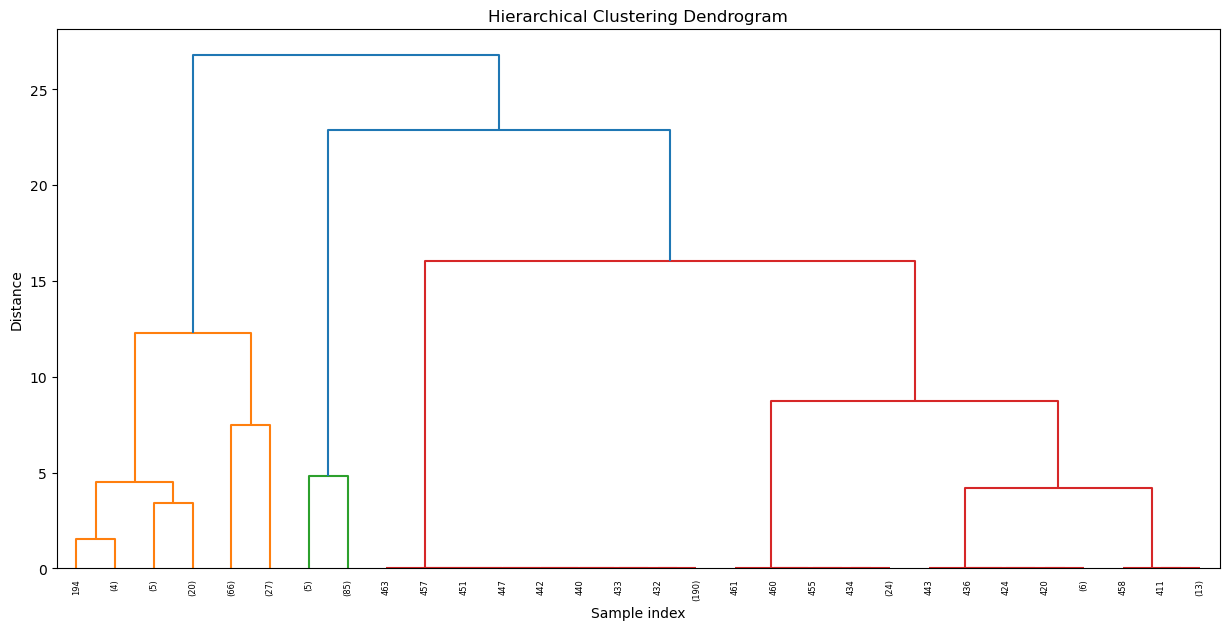

In [77]:
# Select features to be used
features_12 = ['Job', 'Housing']

# Subset the DataFrame
X_12 = X[features_12]

# Generate the linkage matrix
Z_12 = linkage(X_12, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_12, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.show()

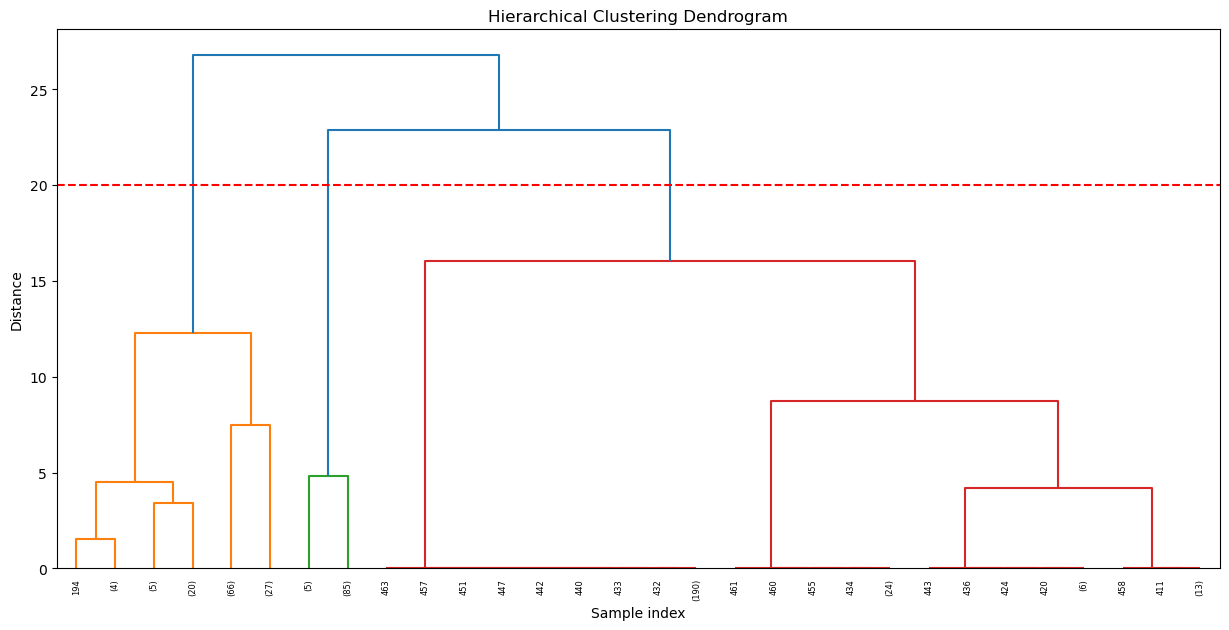

In [78]:
# Set threshold distance and optimal number of clusters
threshold_distance_12 = 20
n_clusters_12 = 3

# Add horizontal line to dendrogram for threshold
plt.figure(figsize=(15, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
dendrogram(Z_12, leaf_rotation=90, leaf_font_size=6, truncate_mode='lastp', p=30)  # Truncate to the last 30 merges
plt.axhline(y=threshold_distance_12, color='r', linestyle='--')  
plt.show()

# Form clusters based on this threshold distance
labels_12 = fcluster(Z_12, threshold_distance_12, criterion='distance')

In [79]:
# Compute evaluation metrics
silhouette_12 = silhouette_score(X_12, labels_12)
print(f"Silhouette Score: {silhouette_12:.6f} \n(Range of possible values is [-1, 1]. The higher the value, the better.)")

davies_bouldin_12 = davies_bouldin_score(X_12, labels_12)
print(f"\nDavies-Bouldin Index: {davies_bouldin_12:.6f} \n(Range of possible values is [0, ∞). The lower the value, the better.)")

Silhouette Score: 0.658330 
(Range of possible values is [-1, 1]. The higher the value, the better.)

Davies-Bouldin Index: 0.623631 
(Range of possible values is [0, ∞). The lower the value, the better.)


## Clustering Results

In [80]:
# Create lists of results
clusterings = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
algorithms = ['KMeans',
              'Hierarchical Clustering',
              'KMeans',
              'Hierarchical Clustering',
              'KMeans',
              'Hierarchical Clustering',
              'KMeans',
              'Hierarchical Clustering',
              'KMeans',
              'Hierarchical Clustering',
              'KMeans',
              'Hierarchical Clustering']
features = [features_1, 
            features_2, 
            features_3, 
            features_4, 
            features_5, 
            features_6,
            features_7,
            features_8,
            features_9,
            features_10,
            features_11,
            features_12]
cluster_counts = [n_clusters_1, 
                  n_clusters_2, 
                  n_clusters_3, 
                  n_clusters_4, 
                  n_clusters_5, 
                  n_clusters_6,
                  n_clusters_7,
                  n_clusters_8,
                  n_clusters_9,
                  n_clusters_10,
                  n_clusters_11,
                  n_clusters_12]
silhouette_scores = [silhouette_1,
                     silhouette_2,
                     silhouette_3,
                     silhouette_4,
                     silhouette_5,
                     silhouette_6,
                     silhouette_7,
                     silhouette_8,
                     silhouette_9,
                     silhouette_10,
                     silhouette_11,
                     silhouette_12]
davies_bouldin_scores = [davies_bouldin_1,
                         davies_bouldin_2,
                         davies_bouldin_3,
                         davies_bouldin_4,
                         davies_bouldin_5,
                         davies_bouldin_6,
                         davies_bouldin_7,
                         davies_bouldin_8,
                         davies_bouldin_9,
                         davies_bouldin_10,
                         davies_bouldin_11,
                         davies_bouldin_12]
inertia_scores = [inertia_1,
                 'Not applicable',
                  inertia_3,
                 'Not applicable',
                  inertia_5,
                 'Not applicable',
                  inertia_7,
                 'Not applicable',
                  inertia_9,
                 'Not applicable',
                  inertia_11,
                 'Not applicable']

# Create the DataFrame
data = {
    'Clustering': clusterings,
    'Algorithm': algorithms,
    'Features': features,
    'Number of clusters': cluster_counts,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Index': davies_bouldin_scores,
    'Inertia': inertia_scores}

results = pd.DataFrame(data)

# Apply styling to center the text in each cell
results = results.style.set_properties(**{'text-align': 'center'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])

# Display the styled DataFrame
results

,Clustering,Algorithm,Features,Number of clusters,Silhouette Score,Davies-Bouldin Index,Inertia
0,1,KMeans,"['Job', 'Housing', 'Sex_male', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc', 'AgeJobInter', 'AgeDurationInter', 'CreditDurationInter']",5,0.184026,1.653774,2484.857308
1,2,Hierarchical Clustering,"['Job', 'Housing', 'Sex_male', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc', 'AgeJobInter', 'AgeDurationInter', 'CreditDurationInter']",3,0.182414,2.020926,Not applicable
2,3,KMeans,"['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc']",6,0.352973,0.964786,872.543308
3,4,Hierarchical Clustering,"['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter', 'PurposeIsBizOrEduc']",6,0.322300,1.005666,Not applicable
4,5,KMeans,"['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']",5,0.366220,0.974776,738.084150
5,6,Hierarchical Clustering,"['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']",5,0.321484,1.047177,Not applicable
6,7,KMeans,"['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']",2,0.315892,1.509277,1429.026372
7,8,Hierarchical Clustering,"['Job', 'Housing', 'CreditToDuration', 'CreditCheckingSavingInter']",2,0.264357,1.867319,Not applicable
8,9,KMeans,"['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Sex_male']",5,0.191069,1.585440,2190.451855
9,10,Hierarchical Clustering,"['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Sex_male']",5,0.162574,1.682198,Not applicable


Of the 12 clustering attempts, Clustering 11 has the highest Silhouette Score, the lowest Davies-Bouldin Index, and the lowest inertia. It makes use of 2 features, and it has 5 clusters. It has a Silhouette Score of 0.825238, a Davies-Bouldin Index of 0.497190, and an inertia of 94.438400. 

In [81]:
# Define final DataFrame
df_final = df[features_11]

# Add the cluster labels as a new column
df_final['Cluster'] = labels_11

# Display the first few rows of the updated DataFrame
df_final.head(20)

,Job,Housing,Cluster
0,2,3,0
1,2,2,1
2,2,2,1
3,3,1,1
4,3,3,3
5,2,1,1
6,2,1,1
7,2,3,0
8,1,3,2
9,2,1,1


In [82]:
# Get frequency of each cluster label
df_final['Cluster'].value_counts()

Cluster
0    198
1    103
2     90
3     43
4     30
Name: count, dtype: int64

# Cluster Analysis

In [83]:
# Group by 'Cluster' and calculate summary statistics
summary_statistics = df_final.groupby('Cluster').describe()

# Display the summary statistics
summary_statistics

Job                                              Housing                                             
         count      mean       std  min  25%  50%  75%  max   count      mean       std  min  25%  50%  75%  max
Cluster                                                                                                         
0        198.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0   198.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
1        103.0  2.097087  0.297525  2.0  2.0  2.0  2.0  3.0   103.0  1.262136  0.441947  1.0  1.0  1.0  2.0  2.0
2         90.0  0.944444  0.230345  0.0  1.0  1.0  1.0  1.0    90.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
3         43.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0    43.0  2.651163  0.482243  2.0  2.0  3.0  3.0  3.0
4         30.0  0.833333  0.379049  0.0  1.0  1.0  1.0  1.0    30.0  1.200000  0.406838  1.0  1.0  1.0  1.0  2.0

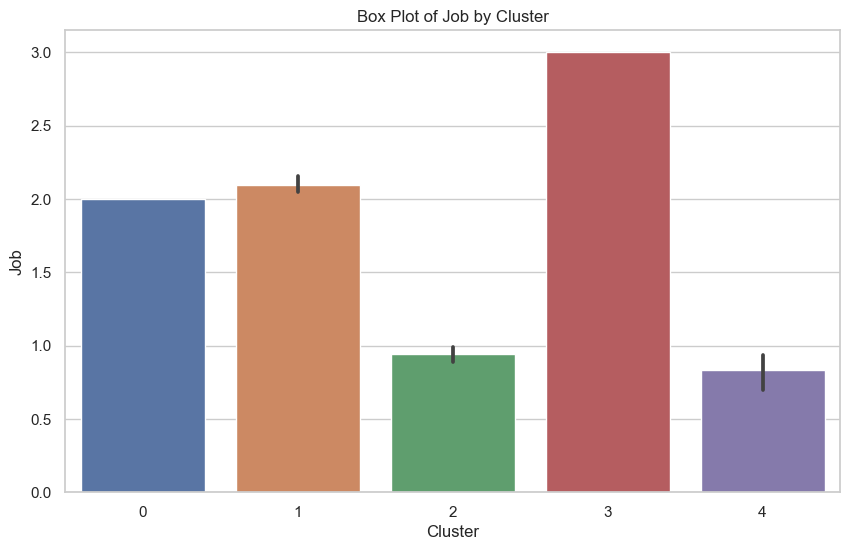

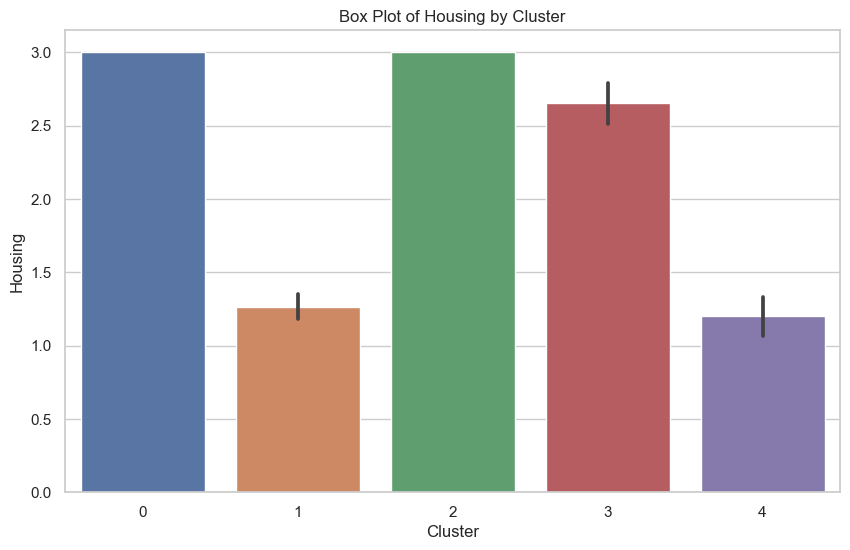

In [84]:
# Create list of features to create box plots for
features = features_11

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Loop through each feature and create a box plot
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cluster', y=feature, data=df_final)
    plt.title(f'Box Plot of {feature} by Cluster')
    plt.show()

Based on the preceding analysis, the five clusters have the following characteristics.

Cluster 0
Mean of 'Job': 2.000000, which is code for 'skilled'
Mean of 'Housing': 3.000000, which is code for 'own'

Applicants in this cluster are (a) skilled and (b) own their place of residence.

Cluster 1
Mean of 'Job': 2.097087, which is close to 2, the code for 'skilled'
Mean of 'Housing': 1.262136, which is close to 1, the code for 'rent'

Applicants in this cluster are (a) skilled and (b) rent their place of residence.

Cluster 2
Mean of 'Job': 0.944444, which is close to 1, the code for 'unskilled and resident'
Mean of 'Housing': 3.000000, which is code for 'own'

Applicants in this cluster are (a) unskilled, (b) have 'resident' status, and (c) own their place of residence.

Cluster 3
Mean of 'Job': 3.000000, which is code for 'highly skilled' 
Mean of 'Housing': 2.651163, which is close to 3, the code for 'own'

Applicants in this cluster are (a) highly skilled and (b) own their place of residence.

Cluster 4
Mean of 'Job': 0.833333, which is close to 1, the code for 'unskilled and resident'
Mean of 'Housing': 1.200000, which is close to 1, the code for 'rent' 

Applicants in this cluster are (a) unskilled, (b) have 'resident' status, and (c) rent their place of residence.


# Conclusion

Twelve clustering attempts were made. The KMeans algorithm was used in half of these attempts, while hierarchical clustering was used in the other half. Of these 12 clustering attempts, the one that performed the best was a KMeans clustering that employed two features and five clusters. Of the 12 attempts, this clustering had the highest Silhouette Score, the lowest Davies-Bouldin Index, and the lowest inertia. Its Silhouette Score was 0.825238, its Davies-Bouldin Index was 0.497190, and its inertia was 94.438400.

The resulting five clusters have the following characteristics:

Cluster 0
Applicants who are (a) skilled and (b) own their place of residence

Cluster 1
Applicants who are (a) skilled and (b) rent their place of residence

Cluster 2
Applicants who are (a) unskilled, (b) have 'resident' status, and (c) own their place of residence

Cluster 3
Applicants who are (a) highly skilled and (b) own their place of residence

Cluster 4
Applicants who are (a) unskilled, (b) have 'resident' status, and (c) rent their place of residence

The German Credit Risk dataset has several limitations and ambiguities that affect its usability and reliability. First, the dataset's columns are not well-described. It is unclear whether the 'Saving accounts' column pertains to savings at the German bank in question or across all banks the person uses. Similarly, it is not specified whether the 'Checking account' column refers to checking accounts at the German bank in question or across all of the person's banks. There is also ambiguity regarding whether the 'Credit amount', 'Duration', and 'Purpose' pertain to existing credit or to credit being applied for.

Moreover, despite being designed for credit risk assessment, the dataset lacks several critical features commonly used in such evaluations. Income is a fundamental factor in assessing an individual's ability to repay credit, but this dataset does not include any income-related data. Information on an individual's credit history and payment behavior is also crucial for evaluating credit risk, yet this dataset does not provide such details.

These issues significantly limit the dataset's effectiveness and the robustness of any clustering developed using it. Without clear descriptions and essential features, it is challenging to perform a reliable segmentation of customers based on credit risk.